In [138]:
using DataFrames
using PythonPlot
using Statistics
using CSV
using JLD2
include("MDPModelFunctions2.jl")

sim_cowan_att (generic function with 1 method)

In [139]:
# read in retrocue_E1_clean.csv
data = CSV.read("retrocue_E1_clean.csv", DataFrame)
first(data,6)

Row,Column1,Subject,trial.number,Observation.id,food.loc,distract.loc,n_searches,delay,load,baiting,interval,first.search.time,first.search.loc,time.to.search,first.search,food.loc.row,food.loc.col,first.search.row,first.search.col
,Int64,String7,Int64,String31,String3,String7,Int64,String1,Int64,Float64,Float64,Float64,String3,Float64,Int64,String1,Int64,String1,Int64
1,1,Alba,1,Alba_E1_S1_T1,C2,None,1,M,1,35.24,10.88,47.64,C2,12.4,1,C,2,C,2
2,2,Alba,10,Alba_E1_S2_T3-4,E1,B1,2,L,2,92.12,10.96,104.48,E3,12.36,0,E,1,E,3
3,3,Alba,11,Alba_E1_S2_T5-6,B3,E2,3,M,2,53.32,10.32,66.24,B1,12.92,0,B,3,B,1
4,4,Alba,12,Alba_E1_S2_T5-6,F1,C2,1,S,2,112.64,7.12,125.04,F1,12.4,1,F,1,F,1
5,5,Alba,13,Alba_E1_S3_T1-6,D2,None,2,M,1,21.72,8.04,32.4,D3,10.68,0,D,2,D,3
6,6,Alba,14,Alba_E1_S3_T1-6,F1,None,3,S,1,66.84,6.76,75.56,F3,8.72,0,F,1,F,3


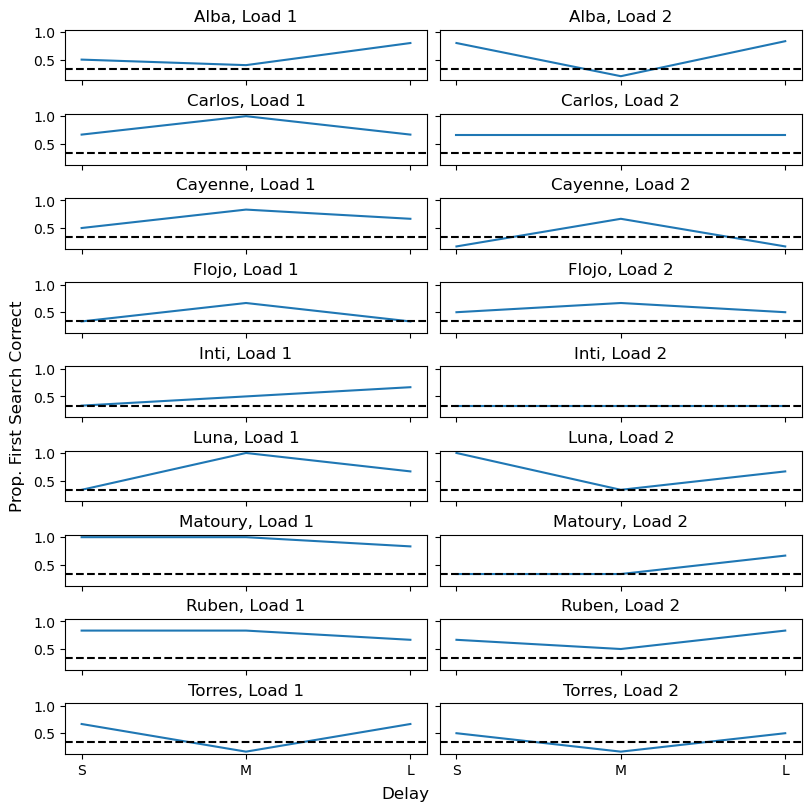

Python: Text(0.5, 0.00520875, 'Delay')

In [140]:

nsubj = length(unique(data[!,:Subject])) # 9 subjects
grouped_df = combine(groupby(data, [:delay, :load, :Subject]), Symbol("first.search") => mean => :mean_n_searches)

using CategoricalArrays

# Ensure the delay column is a categorical variable with specified order
grouped_df.delay = categorical(grouped_df.delay, levels=["S", "M", "L"], ordered=true)


subjects = unique(grouped_df.Subject)
delays = ["S", "M", "L"]
N_delays = length(delays)
loads = [1, 2]
N_loads = length(loads)
colors = Dict(subjects .=> range(0, stop=1, length=length(subjects)))  # Different color for each subject
markers = Dict(1 => "o", 2 => "s")  # Different markers for each load

fig,ax = subplots(nsubj, N_loads, sharey = true, sharex = true, figsize=(8, 8), constrained_layout=true)

subj = subjects[1]

for (s_idx, subj) in enumerate(subjects)
    subj_data = grouped_df[grouped_df.Subject .== subj, :]

    for i in 1:N_loads
        # i = 1
        load = loads[i]
        load_data = subj_data[subj_data.load .== load, :]

        # Sort the load_data dataframe based on delay order
        load_data = sort(load_data, :delay)

        load_delays = convert(Vector{String}, string.(load_data.delay))
        ax[s_idx-1, i-1].plot(load_delays, load_data.mean_n_searches)
        ax[s_idx-1, i-1].set_title("$subj, Load $load")

        # plot a dashed horzontal line at .3333
        ax[s_idx-1, i-1].axhline(y=1/3, color="black", linestyle="--")
    end
end
fig.supylabel("Prop. First Search Correct")
fig.supxlabel("Delay")


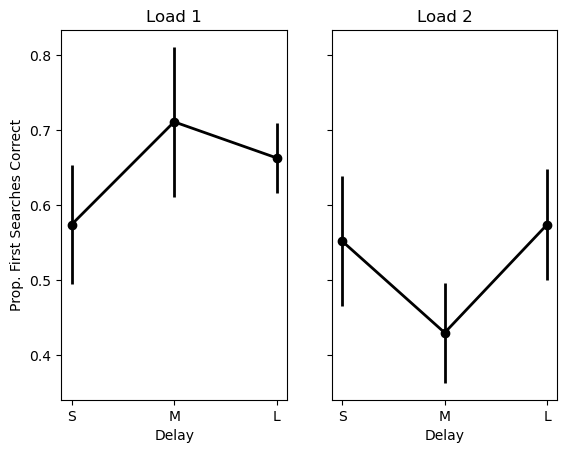

Python: Text(24.000000000000014, 0.5, 'Prop. First Searches Correct')

In [141]:
# take the mean of grouped_df accross subjects
mean_grouped_df = combine(groupby(grouped_df, [:delay, :load]), :mean_n_searches => mean => :mean_n_searches)
# also compute the standard error of the mean
sem(x) = std(x) / sqrt(length(x))
sem_grouped_df = combine(groupby(grouped_df, [:delay, :load]), :mean_n_searches => sem => :sem_n_searches)

fig,ax = subplots(1, N_loads, sharey = true)

for i in 1:N_loads
    load = loads[i]
    load_data = mean_grouped_df[mean_grouped_df.load .== load, :]

    load_delays = convert(Vector{String}, string.(load_data.delay))

    # plot mean with error bars for sem
    ax[i-1].errorbar(load_delays, load_data.mean_n_searches, yerr=sem_grouped_df[sem_grouped_df.load .== load, :sem_n_searches], fmt="-o", color="black", linewidth=2)

    # ax[i-1].plot(load_delays, load_data.mean_n_searches, "-o", color="black", linewidth=2)
    ax[i-1].set_title("Load $load")
    ax[i-1].set_xlabel("Delay")
end
ax[0].set_ylabel("Prop. First Searches Correct")



In [142]:
mean_grouped_df

# make a matrix of mean_n_searches for each load X delay (row should be load 1 then load 2); delay should be S, M, L
mean_perf_data = reshape(mean_grouped_df.mean_n_searches, N_loads, N_delays)

# structure this in the same way that the simulations are saved...

2×3 Matrix{Float64}:
 0.574074  0.711111  0.662963
 0.551852  0.42963   0.574074

In [143]:
# load the results for each parameter combination run...
# list all conditions we want to run
N_Object_Vals = [2, 3]; # this is just 2 and 3, but in practice, it is 1 and 2
N_Seconds_NoCue = [5,7,10]

# parameter values...
NT_vals = [50,100,200,400]#[800]#[25, 50, 100, 200, 400, 800]
# set parameters for each job... 
eps_vals = collect(1:-.02:.01) # 17

# quanta values - could be more fine-grained...
q_vals = collect(2:2:50) #

# memory slopes
mem_slopes = [.05, .1, .2, .4]

4-element Vector{Float64}:
 0.05
 0.1
 0.2
 0.4

In [144]:
# Create list of all parameter combinations
function create_parameter_list(eps_vals, q_vals, NT_vals, mem_slopes)
    all_params = []
    
    for epsilon in eps_vals
        for N_Quanta in q_vals
            for NT_per_Second in NT_vals
                for mem_slope in mem_slopes
                    push!(all_params, Dict(
                        "epsilon" => epsilon,
                        "N_Quanta" => Int(N_Quanta),
                        "NT_per_Second" => Int(NT_per_Second),
                        "mem_slope" => mem_slope
                    ))
                end
            end
        end
    end
    
    return all_params
end


function load_results(N_Quanta, epsilon, NT_per_Second; res_part = "delayed_memory")

    # res_part should either be "delayed_memory" or "retrocue"

    res_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Data/Memory_Models/monkey_sims"
    
    file_name = "N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_$(NT_per_Second).jld2"

    full_file_path = joinpath(res_folder, res_part, file_name)

    results = load(full_file_path)
    
    return results

end


# function to load delay_prob_correct and retro_cue_prob_correct
function load_prob_correct(N_Quanta, epsilon, NT_per_Second)

    # load delayed memory results
    these_res = load_results(N_Quanta, epsilon, NT_per_Second, res_part = "delayed_memory")

    # N_Obj X N_Sec, N_Memslopes - delay_prob_correct
    delay_prob_correct = these_res["delay_prob_correct"]

    return delay_prob_correct

end

# Function to load a single data point and turn it into a feature and target vector
function load_data_point(params)
    delay_prob = load_prob_correct(
        params["N_Quanta"],
        params["epsilon"],
        params["NT_per_Second"]
    )

    mem_slopes = [.05, .1, .2, .4]
    mem_slope_idx = findfirst(x -> isapprox(x, params["mem_slope"], rtol=1e-10), mem_slopes)
    
    if isnothing(mem_slope_idx)
        error("Invalid mem_slope value: $(params["mem_slope"])")
    end
    
    # Extract and flatten features
    delay_features = delay_prob[:, :, mem_slope_idx]
    
    return delay_features
end



load_data_point (generic function with 1 method)

In [145]:
# load all data points...
param_list = create_parameter_list(eps_vals, q_vals, NT_vals, mem_slopes)
param_df = DataFrame(param_list)

N_params = size(param_df, 1)

all_data_points = zeros(N_params, length(N_Object_Vals), length(N_Seconds_NoCue));

for i in 1:N_params
    params = param_list[i]
    data_point = load_data_point(params)
    all_data_points[i, :, :] = data_point
end

two_item_sim_data = all_data_points[:, 1, :];


┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 ~/.julia/packages/JLD2/z3MOM/src/JLD2.jl:300


In [ ]:
### for each parameter value, compute percent correct in the 1 item case...

# so the value is prob_remember - evaluated at the number of quanta with the given mem_slope...
function get_prob_correct_one_item(this_param)
    return prob_remember(this_param["N_Quanta"], mem_slope = this_param["mem_slope"])
end

# compute the probability of correct for each parameter value
one_item_correct = get_prob_correct_one_item.(param_list);

all_sim_one_two = zeros(N_params, 2, N_delays)
for delay_idx = 1:N_delays
    all_sim_one_two[:, 1, delay_idx] = one_item_correct
end
all_sim_one_two[:, 2, :] = two_item_sim_data;

# load all datapoints...
# compute distance between each data point and the mean_perf_data

function compute_distance(data_point, mean_perf_data)
    return sum((data_point .- mean_perf_data).^2)
end

distances = zeros(N_params)

for i in 1:N_params
    data_point = all_sim_one_two[i, :, :]
    distances[i] = compute_distance(data_point, mean_perf_data)
end


param_df[!, :distance] = distances;


In [ ]:
# store distance in a 4-D matrix - indexed by N_Quanta, epsilon, NT_per_Second, mem_slope
distance_matrix = zeros(length(eps_vals), length(q_vals), length(NT_vals), length(mem_slopes))

re_eps = reverse(eps_vals)

for i in 1:N_params
    params = param_list[i]
    distance_matrix[findfirst(x -> x == params["epsilon"], re_eps),
                    findfirst(x -> x == params["N_Quanta"], q_vals),
                    findfirst(x -> x == params["NT_per_Second"], NT_vals),
                    findfirst(x -> x == params["mem_slope"], mem_slopes)] = distances[i]
end

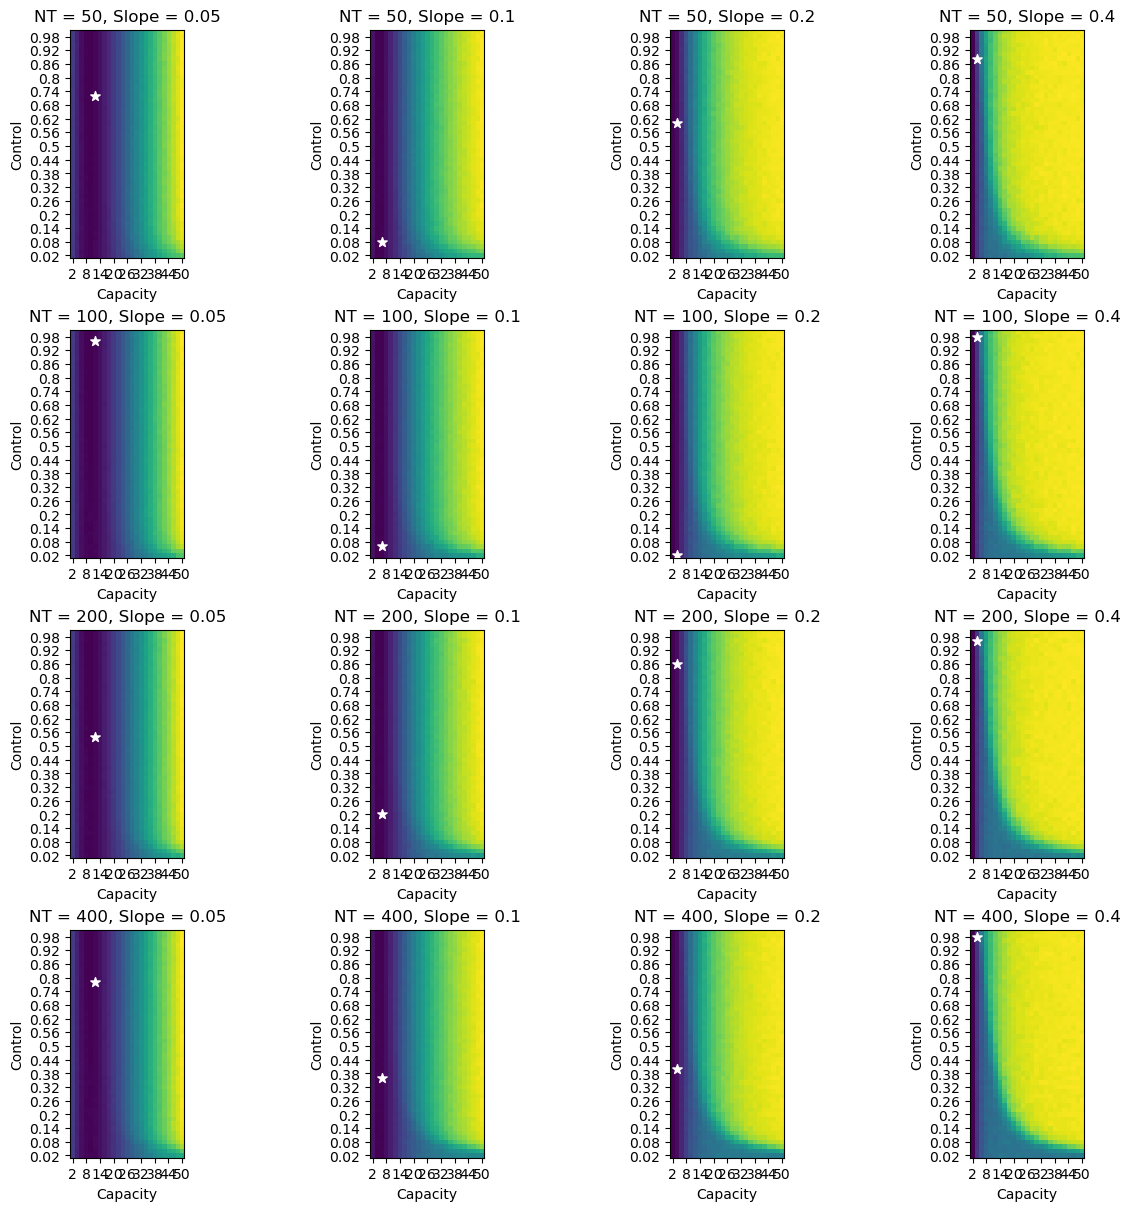

In [169]:
# plot the distance matrix for NT_per_Sec = 400 and mem_slope = .2

# make a subplot for each combination of NT_per_Sec and mem_slope
fig, ax = subplots(length(NT_vals), length(mem_slopes), figsize=(12, 12), constrained_layout=true)

control_vals = round.(1 .- re_eps, digits = 2)

best_eps_all = zeros(length(NT_vals), length(mem_slopes))
best_capacity_all = zeros(length(NT_vals), length(mem_slopes))
best_capacity_control_0_all = zeros(length(NT_vals), length(mem_slopes))
best_capacity_control_2_all = zeros(length(NT_vals), length(mem_slopes))


for i in 1:length(NT_vals)
    for j in 1:length(mem_slopes)
        this_mtx = distance_matrix[:, :, i, j]
        ax[i-1, j-1].imshow(distance_matrix[:, :, i, j], cmap="viridis")
        ax[i-1, j-1].set_title("NT = $(NT_vals[i]), Slope = $(mem_slopes[j])")

        incr_step = 3
        ax[i-1, j-1].set_xticks(0:incr_step:length(q_vals))
        ax[i-1, j-1].set_xticklabels(q_vals[1:incr_step:end])
        ax[i-1, j-1].set_xlabel("Capacity")

        ax[i-1, j-1].set_yticks(1:incr_step:length(control_vals))
        ax[i-1, j-1].set_yticklabels(control_vals[1:incr_step:end])
        ax[i-1,j-1].set_ylabel("Control")

        # Find the index of the minimum distance value
        min_idx = argmin(this_mtx)  # Finds linear index of min value
        min_row, min_col = Tuple(CartesianIndices(this_mtx)[min_idx])  # Convert to (row, col)

        # get minimum control value and capacity value
        best_control = control_vals[min_row]
        best_eps = re_eps[min_row]
        best_eps_all[i, j] = best_eps
        best_capacity = q_vals[min_col]
        best_capacity_all[i, j] = best_capacity

        # get the best_capacity, constraining control to be 0
        best_capacity_control_0 = q_vals[argmin(this_mtx[findfirst(control_vals .== 0), :])]
        best_capacity_control_0_all[i, j] = best_capacity_control_0

        # get the best_capacity, constraining control to be .2
        best_capacity_control_2 = q_vals[argmin(this_mtx[findfirst(control_vals .== .4), :])]
        best_capacity_control_2_all[i, j] = best_capacity_control_2


        ax[i-1, j-1].scatter(min_col, min_row, color="white", marker="*", s=50, label="Min Distance")

    end
end

In [170]:
# pick a value for NT_per_Sec and mem_slope
NT_per_Sec = 400
mem_slope = .05

# get the best capacity for each control value
best_capacity = best_capacity_all[findfirst(x -> x == NT_per_Sec, NT_vals), findfirst(x -> x == mem_slope, mem_slopes)]
best_eps = best_eps_all[findfirst(x -> x == NT_per_Sec, NT_vals), findfirst(x -> x == mem_slope, mem_slopes)]
best_capacity_control_0 = best_capacity_control_0_all[findfirst(x -> x == NT_per_Sec, NT_vals), findfirst(x -> x == mem_slope, mem_slopes)]
best_capacity_control_2 = best_capacity_control_2_all[findfirst(x -> x == NT_per_Sec, NT_vals), findfirst(x -> x == mem_slope, mem_slopes)]

# get the sim data for best for best_eps and best_capacity
best_params = Dict("epsilon" => best_eps, "N_Quanta" => best_capacity, "NT_per_Second" => NT_per_Sec, "mem_slope" => mem_slope)
best_params_control_0 = Dict("epsilon" => 1., "N_Quanta" => best_capacity_control_0, "NT_per_Second" => NT_per_Sec, "mem_slope" => mem_slope)
best_params_control_2 = Dict("epsilon" => .2, "N_Quanta" => best_capacity_control_2, "NT_per_Second" => NT_per_Sec, "mem_slope" => mem_slope)

# get the data values in all_sim_one_two
best_sim_data = all_sim_one_two[findfirst(x -> x == best_params, param_list), :, :]

function get_best_sim_data(NT_per_Sec, mem_slope, capacity, eps, all_sim_one_two, param_list)
    best_params = Dict("epsilon" => eps, "N_Quanta" => capacity, "NT_per_Second" => NT_per_Sec, "mem_slope" => mem_slope)
    best_sim_data = all_sim_one_two[findfirst(x -> x == best_params, param_list), :, :]
    return best_sim_data
end

best_sim_data = get_best_sim_data(NT_per_Sec, mem_slope, best_capacity, best_eps, all_sim_one_two, param_list)
best_sim_data_control_2 = get_best_sim_data(NT_per_Sec, mem_slope, best_capacity_control_2, .6, all_sim_one_two, param_list)
best_sim_data_control_0 = get_best_sim_data(NT_per_Sec, mem_slope, best_capacity_control_0, 1., all_sim_one_two, param_list)





2×3 Matrix{Float64}:
 0.696735  0.696735  0.696735
 0.45976   0.45976   0.45976

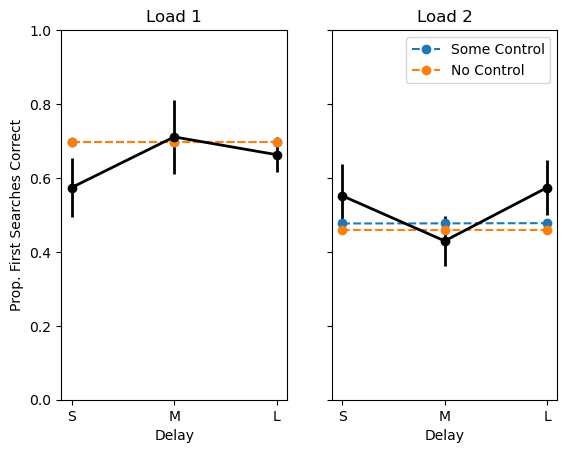

Python: <matplotlib.legend.Legend object at 0x3277c7ed0>

In [163]:

fig,ax = subplots(1, N_loads, sharey = true)

for i in 1:N_loads
    load = loads[i]
    load_data = mean_grouped_df[mean_grouped_df.load .== load, :]

    load_delays = convert(Vector{String}, string.(load_data.delay))

    # plot mean with error bars for sem
    ax[i-1].errorbar(load_delays, load_data.mean_n_searches, yerr=sem_grouped_df[sem_grouped_df.load .== load, :sem_n_searches], fmt="-o", color="black", linewidth=2)
    # ax[i-1].plot(load_delays, best_sim_data[i,:], "--o")
    ax[i-1].plot(load_delays, best_sim_data_control_2[i,:], "--o", label = "Some Control")
    ax[i-1].plot(load_delays, best_sim_data_control_0[i,:], "--o", label = "No Control")


    # ax[i-1].plot(load_delays, load_data.mean_n_searches, "-o", color="black", linewidth=2)
    ax[i-1].set_title("Load $load")
    ax[i-1].set_xlabel("Delay")
end
ax[0].set_ylabel("Prop. First Searches Correct")
ax[0].set_ylim(0,1)
ax[1].legend()


In [ ]:
# create function to simulate retro-cure conditions
function simulate_retrocue(N_Object_Vals, N_Seconds_Pre_Vals, N_Seconds_Post_Vals, mem_slopes, N_Quanta, epsilon, NT_per_Sec; N_Trials = 1000)

    N_N_Object_vals = length(N_Object_Vals)
    N_mem_slopes = length(mem_slopes)
    N_N_Seconds_Pre_Vals = length(N_Seconds_Pre_Vals)
    N_N_Seconds_Post_Vals = length(N_Seconds_Post_Vals)

    # for post cue, always go to the end
    N_Seconds_Post = N_Seconds_Post_Vals[end]
    N_TimeSteps_Post = Int(ceil(N_Seconds_Post * NT_per_Sec))

    retro_cue_prob_correct = zeros(N_N_Object_vals, N_N_Seconds_Pre_Vals, N_N_Seconds_Post_Vals, N_mem_slopes)

    for N_Obj_idx = 1:N_N_Object_vals
        
        N_Objects = N_Object_Vals[N_Obj_idx]
        print(N_Objects)
        
        # loop through all pre-timepoints
        for N_Sec_Pre_idx = 1:length(N_Seconds_Pre_Vals)
            N_Seconds_Pre = N_Seconds_Pre_Vals[N_Sec_Pre_idx]
            N_TimeSteps_Pre = Int(round(N_Seconds_Pre * NT_per_Sec))
            Relevant_Timepoint = Int.(round.((N_Seconds_Pre .+  N_Seconds_Post_Vals).*NT_per_Sec))

            prob_correct = simulate_task_mult_ms(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post, N_Trials, simulate_retrocue_episode, Relevant_Timepoint; mem_slopes = mem_slopes, cue_reliability = 1, baseline_prob = .333)
                
            retro_cue_prob_correct[N_Obj_idx, N_Sec_Pre_idx, :, :] = prob_correct#[Relevant_Timepoint, 1, :]; # also only care about the first item
           #  GC.gc(true)

        end
    end

    return retro_cue_prob_correct

end

# create  function to simulate delayed forgetting conditions
function simulate_delayed_memory(N_Object_Vals, N_Seconds_NoCue, mem_slopes, N_Quanta, epsilon, NT_per_Sec; N_Trials = 1000)
    
    N_N_Object_vals = length(N_Object_Vals)
    N_N_Seconds_NoCue = length(N_Seconds_NoCue)
    N_mem_slopes = length(mem_slopes)

    delay_prob_correct = zeros(N_N_Object_vals, N_N_Seconds_NoCue, length(mem_slopes))

    for N_Obj_idx = 1:N_N_Object_vals

        # First we'll simulate the model without a retro-cue
    
        N_Objects = N_Object_Vals[N_Obj_idx]
        print(N_Objects)
        N_Seconds = N_Seconds_NoCue[end]
    
        N_TimeSteps_Pre = Int(round(N_Seconds * NT_per_Sec))
        N_TimeSteps_Post = 0
        Relevant_Timepoint = Int.(round.(N_Seconds_NoCue.*NT_per_Sec))

    
        # prob correct is Num Time Steps X Num Objects X Num Mem Slopes
        prob_correct = simulate_task_mult_ms(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post, N_Trials, simulate_delayed_memory_episode, Relevant_Timepoint; mem_slopes = mem_slopes, cue_reliability = 1, baseline_prob = .3333)
    
        delay_prob_correct[N_Obj_idx, : , :] = prob_correct#prob_correct[Relevant_Timepoint, 1, :];

        # GC.gc(true)

    end

    return delay_prob_correct

end


function make_retrocue_sims(these_params)

    N_Object_Vals = [2]

    N_Seconds_Pre_Vals = [5,7]
    N_Seconds_Post_Vals = [2,3,5]


    N_Quanta = these_params["N_Quanta"]
    epsilon = these_params["epsilon"]
    NT_per_Second = these_params["NT_per_Second"]
    mem_slope = these_params["mem_slope"]
    mem_slopes = [mem_slope]

    print(epsilon)

    retro_cue_prob_correct = simulate_retrocue(N_Object_Vals, N_Seconds_Pre_Vals, N_Seconds_Post_Vals, mem_slopes, N_Quanta, epsilon, NT_per_Second)

    return retro_cue_prob_correct

end


# make a function to simulate the delayed memory task
function make_delayed_memory_sims(these_params, N_Seconds_NoCue)

    N_Object_Vals = [2]

    N_Quanta = these_params["N_Quanta"]
    epsilon = these_params["epsilon"]
    NT_per_Second = these_params["NT_per_Second"]
    mem_slope = these_params["mem_slope"]
    mem_slopes = [mem_slope]

    print(epsilon)

    delay_prob_correct = simulate_delayed_memory(N_Object_Vals, N_Seconds_NoCue, mem_slopes, N_Quanta, epsilon, NT_per_Second)

    return delay_prob_correct

end


#retro_cue_prob_correct_best_params = make_retrocue_sims(best_params)
retro_cue_prob_correct_best_params_control_0 = make_retrocue_sims(best_params_control_0)
retro_cue_prob_correct_best_params_control_2 = make_retrocue_sims(best_params_control_2)

Sim_N_Seconds_NoCue = [.25, .5, 1, 2,  4, 8]


# do teh same for delayed memory
#delay_prob_correct_best_params = make_delayed_memory_sims(best_params)
delay_prob_correct_best_params_control_0 = make_delayed_memory_sims(best_params_control_0,  Sim_N_Seconds_NoCue)
delay_prob_correct_best_params_control_2 = make_delayed_memory_sims(best_params_control_2, Sim_N_Seconds_NoCue)


1.020.221.020.22

1×7×1 Array{Float64, 3}:
[:, :, 1] =
 0.480434  0.47946  0.479624  0.480907  0.480698  0.47982  0.480127

In [165]:
best_params_control_0

Dict{String, Real} with 4 entries:
  "NT_per_Second" => 400
  "N_Quanta"      => 10.0
  "epsilon"       => 1.0
  "mem_slope"     => 0.05

In [166]:
best_params_control_2

Dict{String, Real} with 4 entries:
  "NT_per_Second" => 400
  "N_Quanta"      => 10.0
  "epsilon"       => 0.2
  "mem_slope"     => 0.05

In [167]:
delay_prob_correct_best_params_control_2

1×7×1 Array{Float64, 3}:
[:, :, 1] =
 0.480434  0.47946  0.479624  0.480907  0.480698  0.47982  0.480127

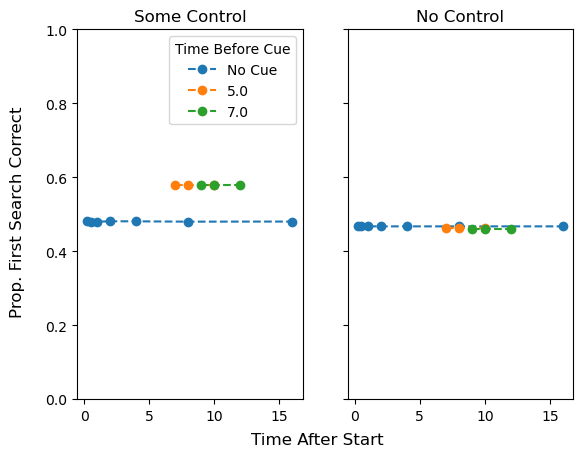

Python: (0.0, 1.0)

In [168]:
N_Object_Vals = [2]

N_Seconds_Pre_Vals = [5,7]
N_Seconds_Post_Vals = [2,3,5]

fig,ax = subplots(1,2, sharey = true, sharex = true)


# plot the no control case
ax[0].set_title("Some Control")
ax[0].plot(Sim_N_Seconds_NoCue, delay_prob_correct_best_params_control_2[1,:], "--o", label = "No Cue")
for N_Sec_Pre_idx = 1:length(N_Seconds_Pre_Vals)
        N_Seconds_Pre = N_Seconds_Pre_Vals[N_Sec_Pre_idx]

        ax[0].plot(N_Seconds_Pre .+ N_Seconds_Post_Vals, retro_cue_prob_correct_best_params_control_2[1, N_Sec_Pre_idx, :], "--o", label = "$(round(N_Seconds_Pre, digits = 2))")
end
ax[0].legend(title = "Time Before Cue")

# plot the some control case in ax 1
ax[1].set_title("No Control")
ax[1].plot(Sim_N_Seconds_NoCue, delay_prob_correct_best_params_control_0[1,:], "--o", label = "No Cue")
for N_Sec_Pre_idx = 1:length(N_Seconds_Pre_Vals)
        N_Seconds_Pre = N_Seconds_Pre_Vals[N_Sec_Pre_idx]

        ax[1].plot(N_Seconds_Pre .+ N_Seconds_Post_Vals, retro_cue_prob_correct_best_params_control_0[1, N_Sec_Pre_idx, :], "--o", label = "$(round(N_Seconds_Pre, digits = 2))")
end

fig.supylabel("Prop. First Search Correct")
fig.supxlabel("Time After Start")

ax[0].set_ylim([0,1])
#fig.suptitle(this_name)


In [ ]:
delay_prob_correct_best_params_control_0

1×3×1 Array{Float64, 3}:
[:, :, 1] =
 0.443858  0.443858  0.443858